In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query, conn)




In [4]:
def run_command(command):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(command)

In [5]:
def show_tables():
    return run_query('''SELECT name, type
              FROM sqlite_master
              WHERE type IN ("table", "view")'''
             )


In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


**Selecting Albums to Purchase**

In [7]:
usa_albums = '''
WITH usa AS (
    SELECT il.*
    FROM invoice_line as il
    INNER JOIN invoice as i ON i.invoice_id = il.invoice_id
    INNER JOIN customer as c ON c.customer_id = i.customer_id
    WHERE c.country = 'USA'
    )
    
SELECT 
    g.name as name,
    COUNT(t.track_id) as num_tracks,
    CAST(COUNT(t.track_id) AS FLOAT)/
        (SELECT COUNT(*) FROM usa) as percentage
    
FROM usa 
INNER JOIN track as t ON t.track_id = usa.track_id
INNER JOIN genre as g ON g.genre_id = t.genre_id
GROUP BY g.name
ORDER BY num_tracks DESC;
'''
run_query(usa_albums)

,name,num_tracks,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [8]:
genre_sales_usa = run_query(usa_albums)
genre_sales_usa.set_index('name', drop=True, inplace=True)

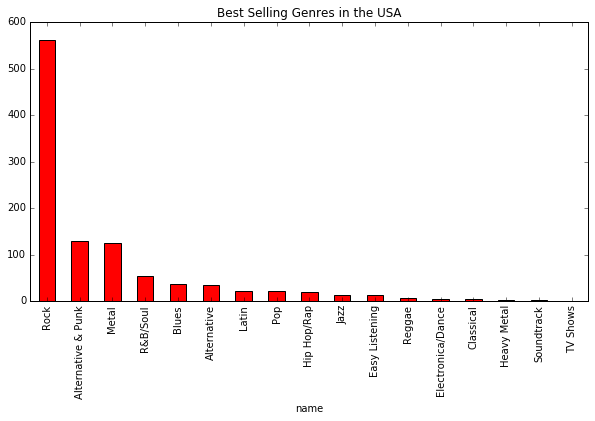

In [9]:
genre_sales_usa['num_tracks'].plot.bar(title='Best Selling Genres in the USA',
                            x='name', 
                            y='num_tracks',
                            colormap=plt.cm.hsv, figsize=(10, 5))



plt.show()

*The best selling genres in USA are shown on the barplot above. Rock genre accounts for a little over half of all sales in the USA, followed by a lesser sales percentage of Alternative & Punk, Metal and R&B/Soul. The 3 artists we will be choosing to add to our Chinook database are following:* 
  
1.Red Tone       
2.Meteor and the Girls     
3.Slim Jim Bites   




**Analyzing Employee Sales Performance**

In [10]:
sales_agents = '''
SELECT e.first_name || " " || e.last_name as sales_agent, ROUND(SUM(i.total), 2) as total
from employee e
inner join customer as c ON c.support_rep_id = e.employee_id
inner join invoice as i ON i.customer_id = c.customer_id
where e.title = 'Sales Support Agent'
GROUP BY 1
'''

run_query(sales_agents)
agents = run_query(sales_agents)
agents.set_index('sales_agent', drop=True, inplace=True)

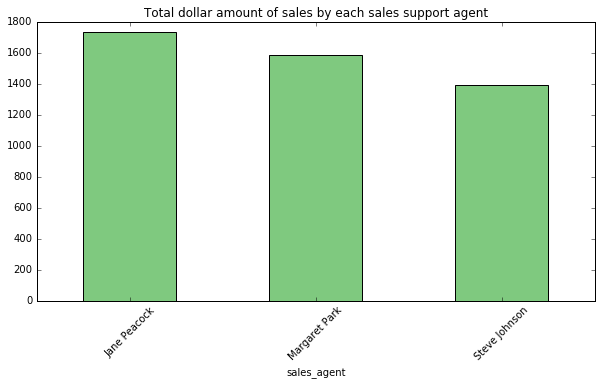

In [11]:
agents['total'].plot.bar(title='Total dollar amount of sales by each sales support agent',
                            x='sales_agent', 
                            y='total',
                            colormap=plt.cm.Accent, figsize=(10, 5), rot=45)

**Analyzing Sales by Country**

In [12]:
customer_other = '''
WITH customer_other AS (
    SELECT 
        CASE 
            WHEN (
            SELECT count(*)
            FROM customer
            WHERE country = c.country
            ) = 1 THEN "Other"
           ELSE c.country
        END AS country,                    
        c.customer_id as id,
        il.invoice_id as invoice_id, 
        il.unit_price as unit_price
    FROM customer as c
    INNER JOIN invoice as i ON i.customer_id=c.customer_id
    INNER JOIN invoice_line as il ON il.invoice_id=i.invoice_id    
    )



SELECT  
       country, 
       total_cust, 
       sales,
       sales / total_cust customer_lifetime_value,
       sales / i_d average_order                 
FROM (
    SELECT country, 
           count(distinct id) as total_cust, 
           SUM(unit_price) as sales, 
           count(distinct invoice_id) as i_d, 
           CASE
            WHEN country = "Other" THEN 1
            ELSE 0
           END AS sort
    FROM customer_other     
    GROUP BY country    
    )
ORDER BY sort, total_cust DESC
'''

run_query(customer_other)
co = run_query(customer_other)
co

,country,total_cust,sales,customer_lifetime_value,average_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,United Kingdom,3,245.52,81.840000,8.768571
6,Czech Republic,2,273.24,136.620000,9.108000
7,India,2,183.15,91.575000,8.721429
8,Portugal,2,185.13,92.565000,6.383793
9,Other,15,1094.94,72.996000,7.448571


**Visualizing Sales by Country**

In [13]:
co.set_index("country", drop=True, inplace=True)

In [14]:
co

,total_cust,sales,customer_lifetime_value,average_order
country,,,,
USA,13,1040.49,80.037692,7.942672
Canada,8,535.59,66.948750,7.047237
Brazil,5,427.68,85.536000,7.011148
France,5,389.07,77.814000,7.781400
Germany,4,334.62,83.655000,8.161463
United Kingdom,3,245.52,81.840000,8.768571
Czech Republic,2,273.24,136.620000,9.108000
India,2,183.15,91.575000,8.721429
Portugal,2,185.13,92.565000,6.383793


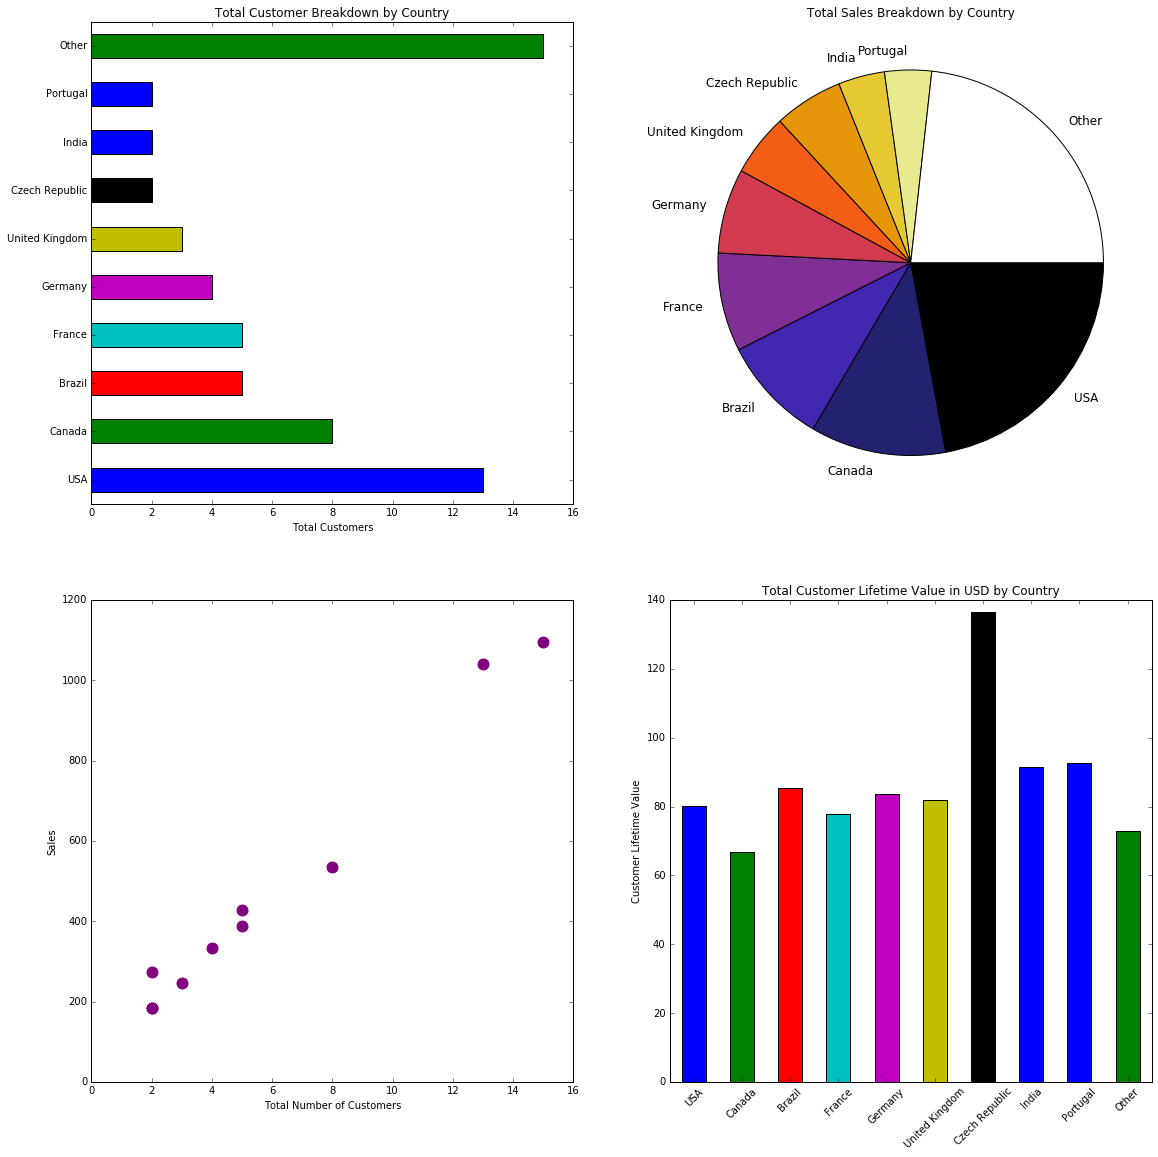

In [15]:
fig = plt.figure(figsize=(19, 19))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
color = plt.cm.CMRmap
#Top Left Graph
co["total_cust"].plot.barh(ax=ax1, title="Total Customer Breakdown by Country")
ax1.set_xlabel("Total Customers")
ax1.set_ylabel("")


#Top Right
co["sales"].plot.pie(ax=ax2, title="Total Sales Breakdown by Country", labeldistance=1.10, fontsize=12, colormap=color, counterclock=False)
ax2.set_ylabel("")
#Bottom Left
ax3.scatter(co["total_cust"], co["sales"], s=120, color='Purple')
ax3.set_ylabel("Sales")
ax3.set_xlabel("Total Number of Customers")

#Bottom Right
co["customer_lifetime_value"].plot.bar(ax=ax4, title="Total Customer Lifetime Value in USD by Country", rot=45)
ax4.set_ylabel("Customer Lifetime Value")
ax4.set_xlabel("")

plt.savefig('sql_chinook.png')
plt.show()


**Albums VS Individual Tracks**

In [16]:
album_and_tracks = '''
WITH invoice_tracks AS (
    SELECT  il.invoice_id as invoice_id,
            MIN(il.track_id) as one_track
    FROM invoice_line as il
    GROUP BY 1    
)

SELECT
    album_purchase,
    COUNT(invoice_id) as number_of_invoice,
    CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(total)
                                       FROM invoice) as percent
    
FROM (
    SELECT it.*,
        CASE 
            WHEN (
                SELECT t.track_id
                FROM track as t
                WHERE t.album_id = (SELECT t2.album_id
                                    FROM track as t2
                                    WHERE t2.track_id = it.one_track)                
                
                EXCEPT
                
                SELECT il2.track_id
                FROM invoice_line as il2
                WHERE il2.invoice_id = it.invoice_id
            ) IS NULL

            AND
        (SELECT il2.track_id
                FROM invoice_line as il2
                WHERE il2.invoice_id = it.invoice_id
         
         EXCEPT
         
         SELECT t.track_id
                FROM track as t
                WHERE t.album_id = (SELECT t2.album_id
                                    FROM track as t2
                                    WHERE t2.track_id = it.one_track
                                    )
         
        
        ) IS NULL
        THEN "yes"
        ELSE "no"
        END AS album_purchase
    FROM invoice_tracks as it


)
GROUP BY album_purchase
'''
run_query(album_and_tracks)
album_or_track = run_query(album_and_tracks)

In [17]:
album_or_track

,album_purchase,number_of_invoice,percent
0,no,500,0.814332
1,yes,114,0.185668


The *whole album* purchases as opposed to purchases of *select tracks* make up 18% of sales, so that's a significant portion of revenue lost if only the most popular tracks from each album are sold. 

**Artists with the Most Songs**

In [19]:
artist_songs = '''
SELECT ar.name as artist_name, COUNT(t.track_id) as number_of_tracks
FROM artist as ar 
INNER JOIN album as al ON al.artist_id=ar.artist_id
INNER JOIN track as t ON al.album_id=t.album_id
GROUP BY 1
ORDER BY 2 DESC
'''

run_query(artist_songs)

,artist_name,number_of_tracks
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Deep Purple,92
5,Lost,92
6,Pearl Jam,67
7,Lenny Kravitz,57
8,Various Artists,56
9,The Office,53
